# Voxelmorph exploration notebook

In [23]:
import sys

sys.path.insert(0, '../')

import tifffile as tiff
import numpy as np
import matplotlib
import voxelmorph as vxm
import tensorflow as tf
import nibabel as nib
import neurite as ne
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
from modules.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    std = video[0].std()
    print('calculated std')
    low = np.quantile(video[0], q=0.01)
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

In [3]:
orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
]

warped_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
]

## Pre-trained model

### SynthMorph

From their GitHub page:

> SynthMorph is a strategy for learning registration without acquired imaging data, producing powerful networks agnostic to contrast induced by MRI ([eprint arXiv:2004.10282](https://arxiv.org/abs/2004.10282)). For a video and a demo showcasing the steps of generating random label maps from noise distributions and using these to train a network, visit [synthmorph.voxelmorph.net](https://synthmorph.voxelmorph.net).
> 
> We provide model files for a ["shapes" variant](https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5) of SynthMorph, that we train using images synthesized from random shapes only, and a ["brains" variant](https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/brains-dice-vel-0.5-res-16-256f.h5), that we train using images synthesized from brain label maps. We train the brains variant by optimizing a loss term that measures volume overlap of a [selection of brain labels](https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/fs-labels.npy). For registration with either model, please use the `register.py` script with the respective model weights.

We will first download the model weights for the "shapes" variant:

In [13]:
!cd ../models && wget https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5

--2021-11-03 11:21:07--  https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.240.105
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85150080 (81M)
Saving to: ‘shapes-dice-vel-3-res-8-16-32-256f.h5.1’

shapes-dice-vel-3-r 100%[===================>]  81.21M  7.64MB/s    in 15s     

2021-11-03 11:21:23 (5.30 MB/s) - ‘shapes-dice-vel-3-res-8-16-32-256f.h5.1’ saved [85150080/85150080]



In [19]:
path = '../data/ref.nii.gz'

# load reference image
ref = nib.load(path).get_fdata()

# min-max normalize
ref = (ref - ref.min()) / ref.max()

# save output
ref = nib.AnalyzeImage(ref, np.eye(4))
nib.save(ref, path)

In [20]:
ref = nib.load('../data/ref.nii.gz').get_fdata()
warped = nib.load('../data/warped.nii.gz').get_fdata()

print(f'reference image shape: {ref.shape}')
print(f'warped image shape: {ref.shape}')

reference image shape: (160, 160, 192)
warped image shape: (160, 160, 192)


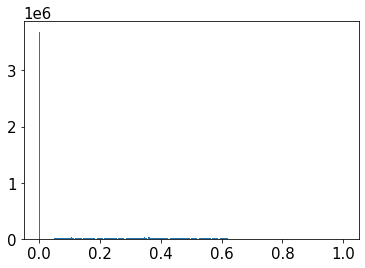

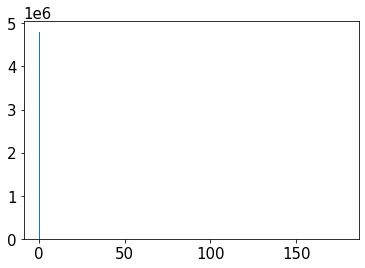

In [21]:
plt.hist(ref.ravel(), bins=200)
plt.show()
plt.hist(warped.ravel(), bins=200)
plt.show()

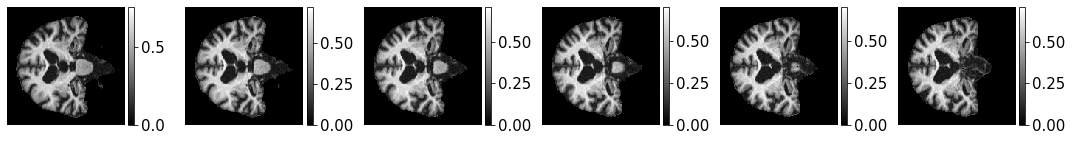

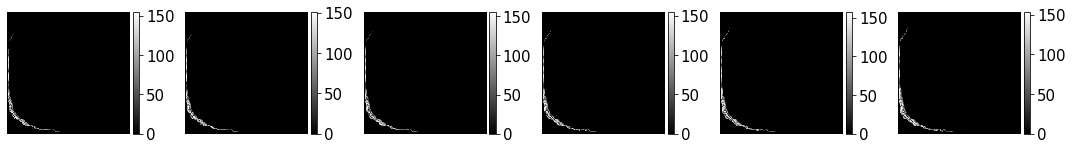

In [38]:
# plot
imgs = [ref[..., i] for i in range(90, 96)]
ne.plot.slices(imgs, cmaps=['gray'], do_colorbars=True)

imgs = [warped[..., i] for i in range(90, 96)]
ne.plot.slices(imgs, cmaps=['gray'], do_colorbars=True);

In [10]:
# our data will be of shape 160 x 192 x 224
vol_shape = (160, 192, 224)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

vxm_model.load_weights('../models/voxelmorph-pretrained-vxm_dense_brain_T1_3D_mse.h5')

ValueError: axes don't match array